<a href="https://colab.research.google.com/github/philsML/Classification_by_Keyword/blob/master/MLwP_Group_Projects_Keywords_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 | Preparation**

*Import all necessary Packages for the following Code, Set Random Seed (to make results reproducible), Mount Google Drive, Load Raw Dataset.*



In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from google.colab import drive
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
random.seed(123)

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
raw=pd.read_csv('/content/drive/My Drive/ML Python_Group Project/train2.csv')

*Choose Subset Size and create random Subset to work with.*

In [0]:
sub_size=20000

In [0]:
subset_IDs = random.sample(set(raw.ID), sub_size)
subset_IDs.sort()

In [0]:
subset = raw[raw.ID.isin(subset_IDs)]

# **1.1 | Basic Dataset Transformation**

*In the keywords-column of the table, all keywords & counts per user are in one string-item that need to be disentangled. Thus, create lists for the IDs, their keywords (as one long string) and their count -> lists should have as many itmes as the subset, i.e. as there are total observations for these users.*

In [0]:
IDs=[]
keywords=[]
keywords_len=[]
for i,j in zip(list(subset.ID),list(subset.keywords)):
    IDs.append(i)
    keywords.append(j)
    keywords_len.append(len(j.split(";")))

*Split "keywords:counts"-items by ; to get a list of individual items of the same form. Then split that list into two lists of only keywords and counts respectively. Sometimes a count is missing - to avoid this bug, insert a try & except and add 0 in the except-cases. The length of both lists should be considerably longer as length now equals observations times keyword-items.*

In [0]:
keywords_list=[]
for i in keywords:
    keywords_list.append(i.split(";"))

In [0]:
keywords_names=[]
keywords_count=[]
for i in keywords_list:
    for j in i:
        keywords_names.append(j.split(":")[0])
        try:
            keywords_count.append(j.split(":")[1])
        except:
            keywords_count.append(0)

*Create an index-list corresponding to the long lists of keywords and counts. I.e. if the first 15 items come from User 200, fill the first 15 positions of the list with "200", then go on to the next User and fill the list with his/her ID as many times as he/she has keywords in the list.*

In [0]:
counter=0
index_list=[]
for x,c in zip(IDs,keywords_len):
        while counter < (c):    
            index_list.append(x)
            counter=counter+1
        counter=0 

*Create a table with three columns: User-ID, Keyword, Count.*

In [0]:
keywords_table=pd.DataFrame(index_list,columns=["ID"])
keywords_table["keywords"]=keywords_names
keywords_table["counts"]=keywords_count

*Check, for how many observations keywords occur. Those with very low occuranes have no value to detect patterns so spare them from the start - saves processing power and memory (less columns in analysis-table).*

In [0]:
sorted_keywords=keywords_names
sorted_keywords.sort()

In [0]:
unique, occurances = np.unique(sorted_keywords, return_counts=True)

In [0]:
keyword_occurances = pd.DataFrame(unique, columns=["unique_keywords"])
keyword_occurances["occurances"] = occurances
keyword_occurances.sort_values(by="occurances",axis=0,ascending=False)

,unique_keywords,occurances
42868,les,22278
25724,des,15547
33680,france,12078
33408,forum,11746
8741,affich,11712
...,...,...
40243,jerome.richet,1
40244,jerome.simonneau1,1
11623,astrocytome,1
40248,jese,1


*Check how many keywords are left at what threshold (as in "how many times must they occur at least to be taken into analysis"), then set the threshold and cut-out all words below it.*

In [0]:
threshold_levels={}
for t in range(0,1000,10):
  threshold_levels[t]=len(keyword_occurances[keyword_occurances.occurances>=t])

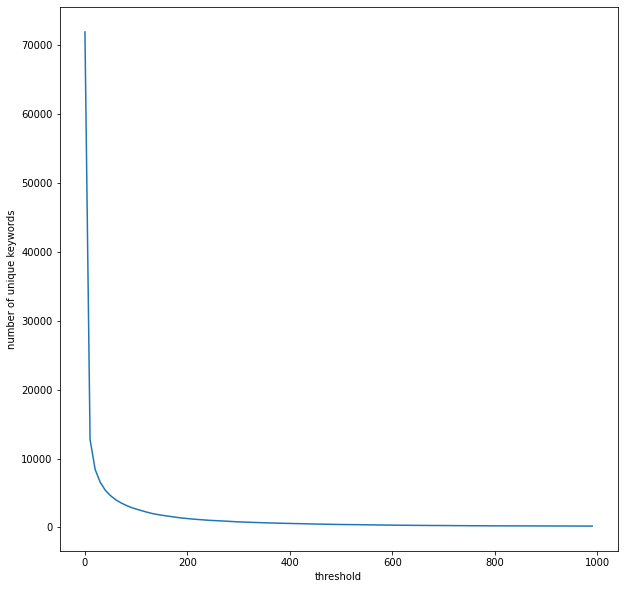

In [0]:
plt.figure(figsize=(10, 10))
plt.plot(list(threshold_levels.keys()),list(threshold_levels.values()))
plt.xlabel("threshold")
plt.ylabel('number of unique keywords')
plt.show()

In [0]:
threshold = sub_size/100 #words should occur at least in 1% of the IDs

In [0]:
cut_out=list(keyword_occurances.unique_keywords[keyword_occurances.occurances<threshold])

# **1.2 | Keywords Cleaning**

*The keywords are not yet clean, that is they contain stopwords, gibberish, etc. These values don't make sense, so create a French stopword-list.*

*  *We could also do some word stemming here? (would have to be before excluding singles)*

In [0]:
raw_stopword_list_1 = stopwords.words('french')
raw_stopword_list_2 = ["Ap.", "Apr.", "GHz", "MHz", "USD", "a", "afin", "ah", "ai", "aie", "aient", "aies", "ait", "alors", "après", "as", "attendu", "au", "au-delà", "au-devant", "aucun", "aucune", "audit", "auprès", "auquel", "aura", "aurai", "auraient", "aurais", "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autour", "autre", "autres", "autrui", "aux", "auxdites", "auxdits", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez", "aviez", "avions", "avons", "ayant", "ayez", "ayons", "b", "bah", "banco", "ben", "bien", "bé", "c", "c'", "c'est", "c'était", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cents", "cependant", "certain", "certaine", "certaines", "certains", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "cf.", "cg", "cgr", "chacun", "chacune", "chaque", "chez", "ci", "cinq", "cinquante", "cinquante-cinq", "cinquante-deux", "cinquante-et-un", "cinquante-huit", "cinquante-neuf", "cinquante-quatre", "cinquante-sept", "cinquante-six", "cinquante-trois", "cl", "cm", "cm²", "comme", "contre", "d", "d'", "d'après", "d'un", "d'une", "dans", "de", "depuis", "derrière", "des", "desdites", "desdits", "desquelles", "desquels", "deux", "devant", "devers", "dg", "différentes", "différents", "divers", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dl", "dm", "donc", "dont", "douze", "du", "dudit", "duquel", "durant", "dès", "déjà", "e", "eh", "elle", "elles", "en", "en-dehors", "encore", "enfin", "entre", "envers", "es", "est", "et", "eu", "eue", "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eûmes", "eût", "eûtes", "f", "fait", "fi", "flac", "fors", "furent", "fus", "fusse", "fussent", "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gr", "h", "ha", "han", "hein", "hem", "heu", "hg", "hl", "hm", "hm³", "holà", "hop", "hormis", "hors", "huit", "hum", "hé", "i", "ici", "il", "ils", "j", "j'", "j'ai", "j'avais", "j'étais", "jamais", "je", "jusqu'", "jusqu'au", "jusqu'aux", "jusqu'à", "jusque", "k", "kg", "km", "km²", "l", "l'", "l'autre", "l'on", "l'un", "l'une", "la", "laquelle", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "lez", "lors", "lorsqu'", "lorsque", "lui", "lès", "m", "m'", "ma", "maint", "mainte", "maintes", "maints", "mais", "malgré", "me", "mes", "mg", "mgr", "mil", "mille", "milliards", "millions", "ml", "mm", "mm²", "moi", "moins", "mon", "moyennant", "mt", "m²", "m³", "même", "mêmes", "n", "n'avait", "n'y", "ne", "neuf", "ni", "non", "nonante", "nonobstant", "nos", "notre", "nous", "nul", "nulle", "nº", "néanmoins", "o", "octante", "oh", "on", "ont", "onze", "or", "ou", "outre", "où", "p", "par", "par-delà", "parbleu", "parce", "parmi", "pas", "passé", "pendant", "personne", "peu", "plus", "plus_d'un", "plus_d'une", "plusieurs", "pour", "pourquoi", "pourtant", "pourvu", "près", "puisqu'", "puisque", "q", "qu", "qu'", "qu'elle", "qu'elles", "qu'il", "qu'ils", "qu'on", "quand", "quant", "quarante", "quarante-cinq", "quarante-deux", "quarante-et-un", "quarante-huit", "quarante-neuf", "quarante-quatre", "quarante-sept", "quarante-six", "quarante-trois", "quatorze", "quatre", "quatre-vingt", "quatre-vingt-cinq", "quatre-vingt-deux", "quatre-vingt-dix", "quatre-vingt-dix-huit", "quatre-vingt-dix-neuf", "quatre-vingt-dix-sept", "quatre-vingt-douze", "quatre-vingt-huit", "quatre-vingt-neuf", "quatre-vingt-onze", "quatre-vingt-quatorze", "quatre-vingt-quatre", "quatre-vingt-quinze", "quatre-vingt-seize", "quatre-vingt-sept", "quatre-vingt-six", "quatre-vingt-treize", "quatre-vingt-trois", "quatre-vingt-un", "quatre-vingt-une", "quatre-vingts", "que", "quel", "quelle", "quelles", "quelqu'", "quelqu'un", "quelqu'une", "quelque", "quelques", "quelques-unes", "quelques-uns", "quels", "qui", "quiconque", "quinze", "quoi", "quoiqu'", "quoique", "r", "revoici", "revoilà", "rien", "s", "s'", "sa", "sans", "sauf", "se", "seize", "selon", "sept", "septante", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez", "serions", "serons", "seront", "ses", "si", "sinon", "six", "soi", "soient", "sois", "soit", "soixante", "soixante-cinq", "soixante-deux", "soixante-dix", "soixante-dix-huit", "soixante-dix-neuf", "soixante-dix-sept", "soixante-douze", "soixante-et-onze", "soixante-et-un", "soixante-et-une", "soixante-huit", "soixante-neuf", "soixante-quatorze", "soixante-quatre", "soixante-quinze", "soixante-seize", "soixante-sept", "soixante-six", "soixante-treize", "soixante-trois", "sommes", "son", "sont", "sous", "soyez", "soyons", "suis", "suite", "sur", "sus", "t", "t'", "ta", "tacatac", "tandis", "te", "tel", "telle", "telles", "tels", "tes", "toi", "ton", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "trente-cinq", "trente-deux", "trente-et-un", "trente-huit", "trente-neuf", "trente-quatre", "trente-sept", "trente-six", "trente-trois", "trois", "très", "tu", "u", "un", "une", "unes", "uns", "v", "vers", "via", "vingt", "vingt-cinq", "vingt-deux", "vingt-huit", "vingt-neuf", "vingt-quatre", "vingt-sept", "vingt-six", "vingt-trois", "vis-à-vis", "voici", "voilà", "vos", "votre", "vous", "w", "x", "y", "z", "zéro", "à", "ç'", "ça", "ès", "étaient", "étais", "était", "étant", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"]

stopword_list=[]
for word in raw_stopword_list_1:
    stopword_list.append(word)
for word in raw_stopword_list_2:
    stopword_list.append(word)
stopword_list=set(stopword_list)

*Transform all keywords to lower-case and remove duplicates and singles. Then, clean the keywords by making sure they're not in the stopword-list. Also delete all that non-alphanumerical gibberish or "words" that are just one letter or number.*

In [0]:
words=[w.lower() for w in keywords_names]
cut_out=[c.lower() for c in cut_out]
words=set(words)
words=words.difference(cut_out)
words=words.difference(stopword_list)

In [0]:
progress=0
printer=0
filtered_words = [] 
for word in words: 
    if word.isalpha() and len(word) > 1: 
        filtered_words.append(word) 
    filtered_words.sort()
    progress=progress+1
    printer=printer+1
    if printer>(len(words)/10):
      print(progress/len(words))
      printer=0     

0.10033167495854063
0.20066334991708126
0.3009950248756219
0.4013266998341625
0.5016583747927031
0.6019900497512438
0.7023217247097844
0.802653399668325
0.9029850746268657


*Shorten the keywords-table to only show lines with keywords from the filtered list and thus to avoid processing/looping over/etc. lines with words, that are not gonna be used later anyways.*

In [0]:
keywords_table = keywords_table[keywords_table.keywords.isin(filtered_words)]

# **1.3 | Setup of Table for Analysis**

*Create an empty table (filled with 0), where the index contains the unique user-IDs (Users come up several times in the raw data, but need to be aggregated in the table for analysis) and each clean keyword makes up one column.*

In [0]:
data=pd.DataFrame(0,columns=filtered_words,index=subset.ID.unique())

In [0]:
data.to_csv('/content/drive/My Drive/ML Python_Group Project/empty.csv',sep=";")

*Fill the table with the counts for each combination of a User-ID and all of his/her keywords.*

In [0]:
progress=0
printer=0
for index in range(0,len(keywords_table)):
  ID=keywords_table.iloc[index,0]
  keyword=keywords_table.iloc[index,1]
  value=keywords_table.iloc[index,2]
  if keyword in filtered_words:
    if data.loc[ID, keyword]==0:
      data.at[ID, keyword] = float(value)
    else:
      basis=data.loc[ID, keyword]
      data.at[ID, keyword] = float(basis) + float(value)
  progress=progress+1
  printer=printer+1
  if printer>(len(keywords_table)/20):
    print(progress/len(keywords_table))
    printer=0

0.05000040138397194
0.10000080276794387
0.1500012041519158
0.20000160553588775
0.2500020069198597
0.3000024083038316
0.35000280968780356
0.4000032110717755
0.45000361245574744
0.5000040138397194
0.5500044152236913
0.6000048166076632
0.6500052179916351
0.7000056193756071
0.750006020759579
0.800006422143551
0.8500068235275229
0.9000072249114949
0.9500076262954668


In [0]:
col_sums = pd.DataFrame(data.sum(),columns=["total"])
col_sums = col_sums.sort_values(by="total")

In [0]:
col_sums.sort_values(by="total",axis=0,inplace=True,ascending=False)

In [0]:
col_sums.head(8)

,total
magazine,68066
people,65519
stars,60526
week,45106
end,40339
france,36420
actu,26847
meteo,23828


*As users come up several times in the raw data, create lists for "Age" and "Sex" for each unique User-ID. Always take the first values of the first instance that they come up in the raw data.*

In [0]:
unique_age=[]
for ID in subset.ID.unique():
  unique_age.append(subset[subset.ID==ID].iloc[0,2])

In [0]:
unique_sex=[]
for ID in subset.ID.unique():
  unique_sex.append(subset[subset.ID==ID].iloc[0,3])

*Include Age & Sex in the new table and "push" to front of the table.*

In [0]:
data["dependent_variable_age"]=unique_age
data["dependent_category_age"]=pd.cut(data.dependent_variable_age, bins=[0, 24, 34, 44, 54, 64, 99], labels=['A', 'B', 'C','D','E','F'])
data["dependent_variable_sex"]=unique_sex

new_cols=["dependent_variable_age","dependent_category_age","dependent_variable_sex"]
for i in data.columns[0:(len(data.columns)-3)]:
    new_cols.append(i)

data=data[new_cols]

*Exclude all rows where all independent variables are equal to 0.*

In [0]:
data = data.loc[(data[new_cols[3:]]!=0).any(1)]

*Save the table to the folder in the Google Drive so it can be loaded and used in another Python-Notebook (for Analysis), without having to re-run this entire code.*

In [0]:
data.to_csv('/content/drive/My Drive/ML Python_Group Project/Table for Analysis_v11.csv',sep=";")